# Training deep models for phosphopeptide retention time prediction

In [ ]:
try:
    from google.colab import drive
    drive.mount("data", force_remount=True)
    wd = "data/Shared drives/Villen_Lab/Anthony Valente/PhosphopediaNotebook/"

except Exception as e:
    print(e)
    wd = "./"

Mounted at data


In [ ]:
import os
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from uuid import uuid4

from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import (
    callbacks, models, layers, 
    optimizers, regularizers, wrappers
)

## Intro

Being able to predict retention time from sequence is becoming ubiquitous in the mass spec literature. Having a predictor like this for Phosphopedia fascilitates tons of interesting analyses. We want the best predictor for our time spent training, so we note that the simplest state of the art retention time predictor is the gated recurrent neural network. Here I will use this architecture first on a filtered set of data, which should hopefully remove a lot of intrinsic error in the data, and then I will attempt to refilter the data to bring back in more examples to train on.

## Utility Classes

#### Encoder

Here, I download a standard encoder that I use in several projects. It makes building integer encodings of the sequence data simpler. I also supply a global vocabulary vector which matches up with DeepPepServer.

In [ ]:
if not os.path.exists("sequence_encoder.py"): 
    url = "https://gist.githubusercontent.com/AnthonyOfSeattle/43b932bcb9b5b4b00ccbe96c29769db9/raw/5a1e0d6f3ad35f0a1ba1a9a0a334cd6a7b37e841/sequence_encoder.py"
    r = requests.get(url)
    with open("sequence_encoder.py", "wb") as f:
        f.write(r.content)

from sequence_encoder import SequenceEncoder

GLOBAL_VOCAB = {
    "X": 0,
    "n[42]": 1,
    "A": 2,
    "C": 3,
    "C[57]": 3,
    "D": 4,
    "E": 5,
    "F": 6,
    "G": 7,
    "H": 8,
    "I": 9,
    "K": 10,
    "L": 11,
    "M": 12,
    "N": 13,
    "P": 14,
    "Q": 15,
    "R": 16,
    "S": 17,
    "T": 18,
    "U": 19,
    "V": 20,
    "W": 21,
    "Y": 22,
    "M[16]": 23,
    "S[80]": 24,
    "T[80]": 25,
    "Y[80]": 26
    }


#### Grid Seach API

In [ ]:
class CheckpointGridSearch:
    def __init__(self,
                 model_fn,
                 param_grid,
                 save_dir):
        self.model_fn = model_fn

        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

        self.grid_file = os.path.join(self.save_dir, "param_grid.csv")
        self.grid_df = self._build_grid_df(param_grid)
        self.grid_df.to_csv(self.grid_file, index=False)   

    def _build_grid_df(self, param_grid):
        grid_df = pd.DataFrame.from_records(ParameterGrid(param_grid))
        grid_df["name"] = [str(uuid4()) for ind in range(grid_df.shape[0])]
        grid_df["best_model_train"] = np.zeros(grid_df.shape[0], dtype=np.float32)
        grid_df["best_model_val"] = np.zeros(grid_df.shape[0], dtype=np.float32)
        grid_df["success"] = np.zeros(grid_df.shape[0], dtype=bool)

        if os.path.exists(self.grid_file):
            old_grid_df = pd.read_csv(self.grid_file)
            assert grid_df.shape == old_grid_df.shape
            grid_df = pd.concat(
                [old_grid_df, grid_df]
            )

        grid_df = grid_df.drop_duplicates([col for col in param_grid.keys()])
        return grid_df

    def fit(self, *args, **kwargs):
        for model_ind in range(self.grid_df.shape[0]):
            name = self.grid_df.name[model_ind]
            if self.grid_df.success[model_ind]:
                print("Skipping model {} with name {}.".format(model_ind, name))
                continue
            else:
                print("Currently training " + name)

            model_dir = os.path.join(self.save_dir, name)
            checkpoint_dir = os.path.join(model_dir, "checkpoints")
            os.makedirs(checkpoint_dir, exist_ok=True)

            cur_params = self.grid_df.iloc[model_ind,:-4]
            cur_model = self.model_fn(**cur_params)

            model_dir = os.path.join(self.save_dir, name)
            os.makedirs(model_dir, exist_ok=True)
            with open(os.path.join(model_dir, "model_config.json"), "w") as dest:
                dest.write(cur_model.to_json())

            callback_list = [
                callbacks.ModelCheckpoint(
                    filepath=os.path.join(model_dir,  
                                          "best_model_weights.h5"),
                    save_weights_only=True,
                    save_best_only=True
                    ),
                callbacks.ModelCheckpoint(
                    filepath=os.path.join(checkpoint_dir,
                                          "model_checkpoint.{epoch}.h5"),
                    save_weights_only=True
                    )
                ]
            history = cur_model.fit(*args, **kwargs,
                                    callbacks=callback_list)
            
            history_df = pd.DataFrame.from_records(history.history)
            history_df.to_csv(os.path.join(model_dir, "history.csv"),
                              index=False)
            
            best_ind = history_df.val_loss.argmin()
            self.grid_df.best_model_train.values[model_ind] = history_df.loss[best_ind]
            self.grid_df.best_model_val.values[model_ind] = history_df.val_loss[best_ind]
            self.grid_df.success.values[model_ind] = True
            self.grid_df.to_csv(self.grid_file, index=False)
            break

## Models

In [ ]:
def build_gru_regressor(seq_length=40,
                        vocab_size=20,
                        embedding_dim=8,
                        embeddings_l2=1e-3,
                        hidden_units=32,
                        gru_dropout=0.,
                        gru_recurrent_dropout=0.,
                        output_dim=1,
                        learning_rate=1e-3
                        ):
    model = models.Sequential()
    model.add(
        layers.InputLayer(input_shape=(seq_length,))
        )
    model.add(
        layers.Embedding(input_dim=vocab_size,
                         output_dim=embedding_dim,
                         embeddings_regularizer=regularizers.l2(embeddings_l2),
                         mask_zero=True)
        )
    model.add(
        layers.GRU(units=hidden_units,
                   dropout=gru_dropout,
                   recurrent_dropout=gru_recurrent_dropout)
        )
    model.add(
        layers.Dense(units=output_dim)
        )
    
    model.compile(optimizer=optimizers.Adam(
                                learning_rate=learning_rate
                                ),
                  loss='mean_squared_error')
    
    return model

## Model Building

### Data Loading

In [ ]:
train = pd.read_csv(wd + "data/modeling_splits/update_20210902/retention_time_train.csv")
valid = pd.read_csv(wd + "data/modeling_splits/update_20210902/retention_time_valid.csv")

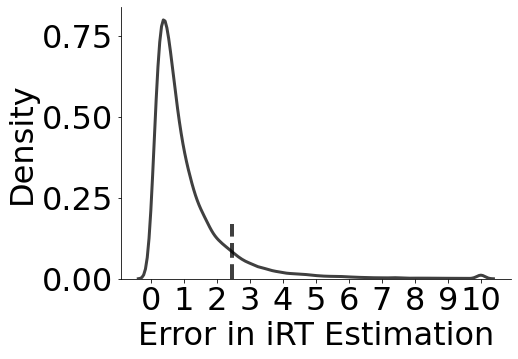

In [ ]:
fig = plt.figure(figsize=(7, 5))

sns.kdeplot(np.minimum(train.test_error, 10),
            c="black",
            lw=3,
            alpha=.75)
plt.axvline(x=np.quantile(train.test_error[~train.test_error.isna()], .9),
            ymax=.2,
            lw=4,
            c="black",
            alpha=.75,
            linestyle="dashed",
            zorder=-1)

plt.xticks(np.arange(11))
plt.tick_params(labelsize=32)
plt.xlabel("Error in iRT Estimation", size=32)
plt.ylabel("Density", size=32)
fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.show()

Many training examples have quite high iRT error, and I would like to leave these out from training. Another approach would be to use sample weights, but this would only increase the amount of hits I have by a small amount and may bias towards easier parts of the gradient.

#### Grid Search -- Single Layer GRU -- Filtered Data

In [ ]:
quantile_cutoff = .9

filtered_train = train[~train.test_error.isna()]
train_error_cutoff = np.quantile(filtered_train.test_error, quantile_cutoff)
filtered_train = filtered_train[filtered_train.test_error < train_error_cutoff]
print("Cutting train data off at median error of {:.2f}, resulting in {} examples".format(
    train_error_cutoff,
    filtered_train.shape[0]
    ))

filtered_valid = valid[~valid.test_error.isna()]
filtered_valid = filtered_valid[filtered_valid.test_error < train_error_cutoff]
print("Cutting valid data off at median error of {:.2f}, resulting in {} examples".format(
    train_error_cutoff,
    filtered_valid.shape[0]
    ))

Cutting train data off at median error of 2.46, resulting in 95230 examples
Cutting valid data off at median error of 2.46, resulting in 11782 examples


In [ ]:
encoder = SequenceEncoder(pattern="[A-Zn][^A-Zn]*",
                          vocab=GLOBAL_VOCAB,
                          seq_len=75)
scaler = StandardScaler()

filtered_train_X = encoder.transform(filtered_train.sequence)
filtered_train_y = scaler.fit_transform(
                       filtered_train.learned_rt.values.reshape(-1, 1)
                       ).flatten()

filtered_valid_X = encoder.transform(filtered_valid.sequence)
filtered_valid_y = scaler.transform(
                       filtered_valid.learned_rt.values.reshape(-1, 1)
                       ).flatten()

In [ ]:
cgs = CheckpointGridSearch(
    model_fn = build_gru_regressor,
    param_grid = dict(seq_length=[75],
                      vocab_size=[max(GLOBAL_VOCAB.values()) + 1],
                      embedding_dim=[8],
                      embeddings_l2=[1e-3],
                      hidden_units=[512],
                      gru_dropout=[.1],
                      gru_recurrent_dropout=[.5],
                      output_dim=[1],
                      learning_rate=[1e-3]),
    save_dir = wd + "trained_models/update_20210902/retention_time/phospho_single_layer_gru"
)

cgs.grid_df

,embedding_dim,embeddings_l2,gru_dropout,gru_recurrent_dropout,hidden_units,learning_rate,output_dim,seq_length,vocab_size,name,best_model_train,best_model_val,success
0,8,0.001,0.1,0.5,512,0.001,1,75,27,2fc8d3d6-2f2f-4284-bfec-48a6cd5d2110,0.009415,0.009393,True


In [ ]:
cgs.fit(filtered_train_X,
        filtered_train_y,
        verbose=1,        
        epochs=400,
        batch_size=512,
        validation_data=(filtered_valid_X, filtered_valid_y))

Skipping model 0 with name 2fc8d3d6-2f2f-4284-bfec-48a6cd5d2110.


#### Grid Search -- Single Layer GRU -- Refiltered Data

I have left this section in for posterities sake, but this idea did not pan out as well as I would have hoped. Others can feel free to run it and see if things pan out differently for them.

In [ ]:
def make_model_loader(model_dir):
    def load_previous_model(learning_rate=0., *args, **kwargs):
        config_json = open(os.path.join(model_dir, "model_config.json"), "rb").read()
        model = models.model_from_json(config_json)
        model.load_weights(os.path.join(model_dir, "best_model_weights.h5"))

        model.compile(optimizer=optimizers.Adam(
                                learning_rate=learning_rate
                                ),
                      loss='mean_squared_error')

        return model

    return load_previous_model

In [ ]:
refilter_model = make_model_loader(wd + "trained_models/update_20210902/retention_time/phospho_single_layer_gru/2fc8d3d6-2f2f-4284-bfec-48a6cd5d2110/")()

In [ ]:
quantile_cutoff = .9
train_rt_pred = refilter_model.predict(encoder.transform(train.sequence))
train_square_errors = (train.learned_rt.values.flatten() - scaler.inverse_transform(train_rt_pred).flatten())**2
train_error_cutoff = np.quantile(train_square_errors[~np.isnan(train_square_errors)], 
                                 quantile_cutoff)

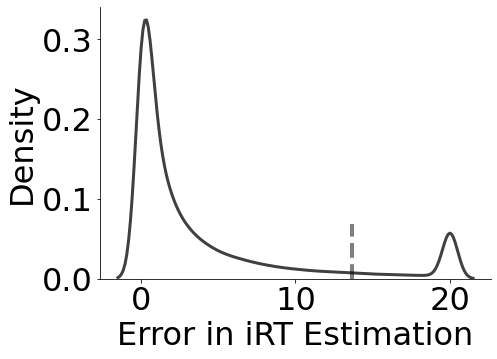

In [ ]:
fig = plt.figure(figsize=(7, 5))
sns.kdeplot(np.minimum(train_square_errors, 20),
            c="black",
            lw=3,
            alpha=.75)
plt.axvline(x=train_error_cutoff,
            ymax=.2,
            lw=4,
            c="black",
            alpha=.5,
            linestyle="dashed",
            zorder=-1)

plt.tick_params(labelsize=32)
plt.xlabel("Error in iRT Estimation", size=32)
plt.ylabel("Density", size=32)
fig.get_axes()[0].spines["right"].set_visible(False)
fig.get_axes()[0].spines["top"].set_visible(False)

plt.show()

In [ ]:
refiltered_train = train[np.logical_and(~np.isnan(train_square_errors), 
                                        train_square_errors < train_error_cutoff)]
print("Cutting train data off  error of {:.2f}, resulting in {} examples".format(
    train_error_cutoff,
    refiltered_train.shape[0]
    ))

Cutting train data off  error of 13.67, resulting in 194546 examples


In [ ]:
encoder = SequenceEncoder(pattern="[A-Zn][^A-Zn]*",
                          vocab=GLOBAL_VOCAB,
                          seq_len=75)
scaler = StandardScaler()

refiltered_train_X = encoder.transform(refiltered_train.sequence)
refiltered_train_y = scaler.fit_transform(
                         refiltered_train.learned_rt.values.reshape(-1, 1)
                         ).flatten()

In [ ]:
cgs = CheckpointGridSearch(
    model_fn = make_model_loader(wd + "trained_models/update_20210902/retention_time/phospho_single_layer_gru/2fc8d3d6-2f2f-4284-bfec-48a6cd5d2110/"),
    param_grid = dict(seq_length=[75],
                      vocab_size=[max(GLOBAL_VOCAB.values()) + 1],
                      embedding_dim=[8],
                      embeddings_l2=[1e-3],
                      hidden_units=[512],
                      gru_dropout=[.1],
                      gru_recurrent_dropout=[.5],
                      output_dim=[1],
                      learning_rate=[1e-3]),
    save_dir = wd + "trained_models/update_20210902/retention_time/phospho_single_layer_gru_refilter"
)

cgs.grid_df

,embedding_dim,embeddings_l2,gru_dropout,gru_recurrent_dropout,hidden_units,learning_rate,output_dim,seq_length,vocab_size,name,best_model_train,best_model_val,success
0,8,0.001,0.1,0.5,512,0.001,1,75,27,0a0671fd-426c-438c-91ed-f6f96c616acd,0.0,0.0,False


In [ ]:
# cgs.fit(refiltered_train_X,
#         refiltered_train_y,
#         verbose=1,        
#         epochs=100,
#         batch_size=1024,
#         validation_data=(filtered_valid_X, filtered_valid_y))

## Evaluating favorite models on validation

### Load correct data

In [ ]:
train = pd.read_csv(wd + "data/modeling_splits/update_20210902/retention_time_train.csv")
valid = pd.read_csv(wd + "data/modeling_splits/update_20210902/retention_time_valid.csv")

In [ ]:
quantile_cutoff = .9

train = train[~train.test_error.isna()]
train_error_cutoff = np.quantile(train.test_error, quantile_cutoff)
train = train[train.test_error < train_error_cutoff]
print("Cutting train data off at median error of {:.2f}, resulting in {} examples".format(
    train_error_cutoff,
    train.shape[0]
    ))

valid = valid[~valid.learned_rt.isna()]
print("Valid left as is, resulting in {} examples".format(
    valid.shape[0]
    ))

Cutting train data off at median error of 2.46, resulting in 95230 examples
Valid left as is, resulting in 27012 examples


In [ ]:
encoder = SequenceEncoder(pattern="[A-Zn][^A-Zn]*",
                          vocab=GLOBAL_VOCAB,
                          seq_len=75)
scaler = StandardScaler()

train_X = encoder.transform(train.sequence)
train_y = scaler.fit_transform(
              train.learned_rt.values.reshape(-1, 1)
              ).flatten()

valid_X = encoder.transform(valid.sequence)
valid_y = scaler.transform(
              valid.learned_rt.values.reshape(-1, 1)
              ).flatten()

In [ ]:
valid.sort_values("learned_rt")

,Unnamed: 0,sequence,learned_rt,qvalue,hits,test_error
8813,5271,ASAS[80]SFAQGISMEAMSENKMVPS[80]EFSTGPVEK,-21.112116,0.005529,1.0,NaN
21085,70471,ESGTEHHRGPSTSRSS[80]PNK,-8.097098,0.002385,6.0,NaN
24846,51776,TGKTEDDSS[80]PKK,-7.362362,0.008564,1.0,NaN
4025,49288,AES[80]GKEEDKK,-5.658279,0.004972,4.0,NaN
562,172795,GS[80]PHSEGGKRSPEPNK,-4.869538,0.007742,1.0,NaN
...,...,...,...,...,...,...
8090,84788,VEEAS[80]PGRPS[80]SVDTLLS[80]PTALIDSILR,115.425962,0.000101,16.0,NaN
17906,266255,IC[57]SS[80]PVQSLLDLFQTS[80]EEK,117.285326,0.000101,1.0,NaN
1462,87856,GVLAC[57]LDGY[80]MNIALEQTEEYVNGQLK,119.134322,0.000281,1.0,NaN
16091,174118,SGS[80]RRGSFDATGNSSY[80]SYSYSFSSSSIGH,121.096316,0.000787,1.0,NaN


### Util

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_best_model(model_dir):
    config_json = open(os.path.join(model_dir, "model_config.json"), "rb").read()
    model = models.model_from_json(config_json)
    model.load_weights(os.path.join(model_dir, "best_model_weights.h5"))

    return model

In [ ]:
def plot_history(history_df):
    fig = plt.figure(figsize=[12, 5])

    plt.plot(history_df.index.values + 1,
             history_df.loss.values,
             lw=4, alpha=.75,
             c="#461554",
             label="Training Loss")
    
    plt.plot(history_df.index.values + 1,
             history_df.val_loss.values,
             lw=4, alpha=.75,
             c="#56c566",
             label="Validation Loss")
    
    best_val_loss = history.val_loss.min()
    plt.axhline(best_val_loss, lw=4,
                c="black", alpha=.5,
                linestyle="--")
    plt.text(x=5, y=1.1*best_val_loss,
             s="{:.4f}".format(best_val_loss),
             size = 32)
    
    plt.xlim(0, history_df.shape[0])
    plt.tick_params(labelsize=32)
    plt.xlabel("Epoch", size=32)
    plt.ylabel("Mean Square Error", size=32)
    plt.yscale("log")
    plt.legend(fontsize=28)

    fig.get_axes()[0].spines["right"].set_visible(False)
    fig.get_axes()[0].spines["top"].set_visible(False)

In [ ]:
def plot_correlation(y, pred_y):
    y, pred_y = y.flatten(), pred_y.flatten()
    
    plt.figure(figsize=(10, 10))

    plt.scatter(y, pred_y, 
                c="black", 
                alpha=.1, 
                s=10)
    
    # Grab correlations and insert into figure
    corr = np.corrcoef(y, pred_y)[0,1]
    plt.text(100, 20, s="Correlation: %.3f" % corr, size = 22, ha="right")

    abs_diff = np.abs(y - pred_y)
    delta_irt = np.quantile(abs_diff, .95)
    plt.text(100, 10, 
             s="95%% delta-iRT: %.3f" % delta_irt, 
             size = 22,
             ha="right")

    delta_irt = np.median(abs_diff)
    plt.text(100, 0, 
             s="Median delta-iRT: %.3f" % delta_irt, 
             size = 22, 
             ha="right")

    plt.xlim(-10, 110)
    plt.ylim(-10, 110)

    plt.xlabel("Predicted iRT", size=24)
    plt.ylabel("Database iRT", size=24)
    plt.tick_params(labelsize=22)

    plt.show()

In [ ]:
def corr_by_count(y, pred_y, count):
    y, pred_y, count = y.flatten(), pred_y.flatten(), count.flatten()
    cutoffs = np.arange(int(np.min(count)), 1000)
    corr_list = []
    for c in cutoffs:
        select = count >= c
        corr_list.append(
            np.corrcoef(y[select], pred_y[select])[0,1]
        )
        
    plt.figure(figsize=[12,3])

    plt.plot(cutoffs, corr_list, lw=3)

    plt.xlim(.9, 1500)
    plt.xscale("log")
    plt.yticks([.985, .99, .995, 1.])
    plt.tick_params(labelsize=22)
    plt.show()

    plt.figure(figsize=[12, 5])

    abs_diff = np.abs(y - pred_y)
    plt.scatter(
        count,
        abs_diff,
        c="black", alpha=.3, s=5
    )

    plt.xlim(.9, 1500)
    plt.xscale("log")
    #plt.ylim(-0.1, 2.5)
    plt.xlabel("Number of examples for iRT estimation", size=24)
    plt.ylabel("Error in prediction", size=24)
    plt.tick_params(labelsize=22)

### Eval

In [ ]:
model_dir = "trained_models/update_20210902/retention_time/phospho_single_layer_gru/"
model_name = "2fc8d3d6-2f2f-4284-bfec-48a6cd5d2110"

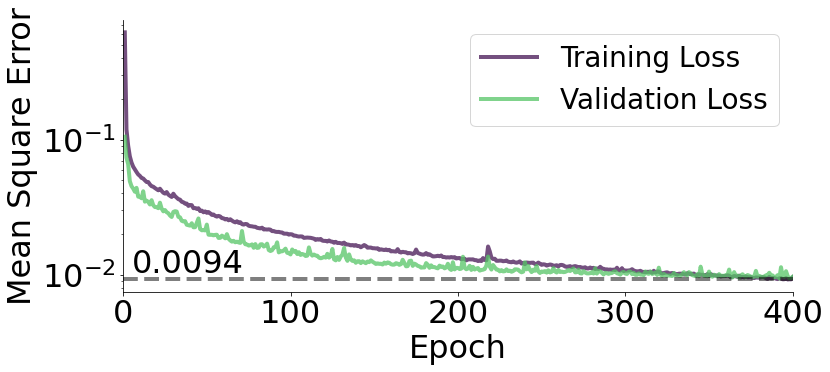

In [ ]:
history = pd.read_csv(os.path.join(wd, model_dir, model_name, "history.csv"))
plot_history(history)
plt.savefig(wd + "figures/rt_data_train_val_curve.svg",
            bbox_inches="tight")
plt.show()

The training for this model definitely seems to be near convergence, which I believe implies that we would not get much better results from any further training.

In [ ]:
%%time
model = get_best_model(os.path.join(wd, model_dir, model_name))

CPU times: user 243 ms, sys: 5.01 ms, total: 248 ms
Wall time: 250 ms


In [ ]:
%%time
pred_valid_y = model.predict(valid_X)

CPU times: user 21.7 s, sys: 194 ms, total: 21.9 s
Wall time: 21.4 s


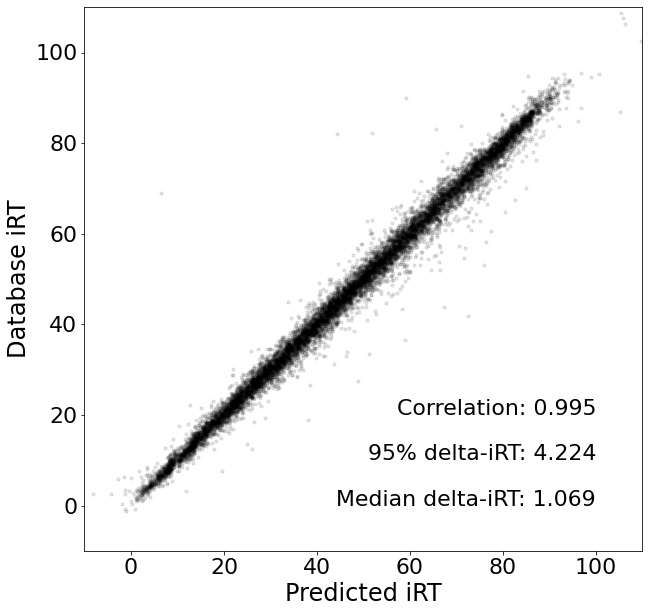

In [ ]:
plot_correlation(scaler.scale_*valid_y[valid.hits.values >= 5] + scaler.mean_, 
                 scaler.scale_*pred_valid_y[valid.hits.values >= 5] + scaler.mean_)

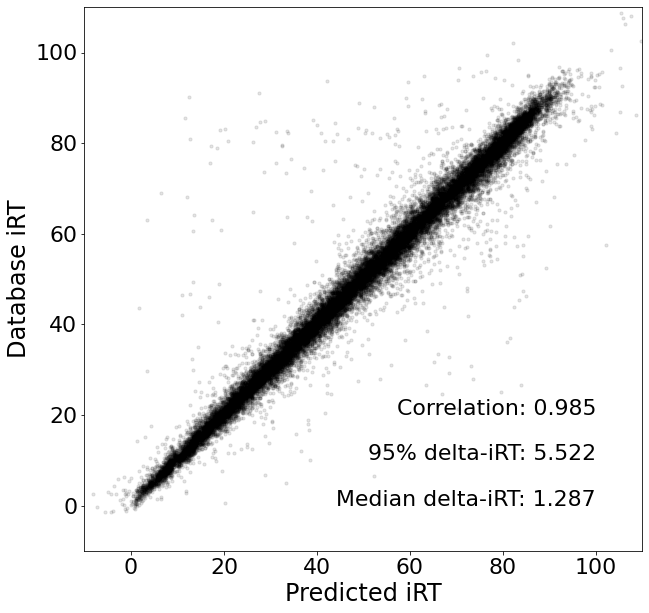

In [ ]:
plot_correlation(scaler.scale_*valid_y + scaler.mean_, 
                 scaler.scale_*pred_valid_y + scaler.mean_)

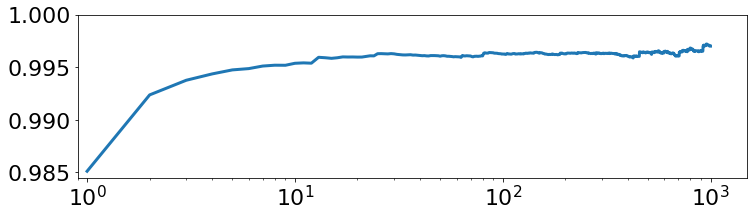

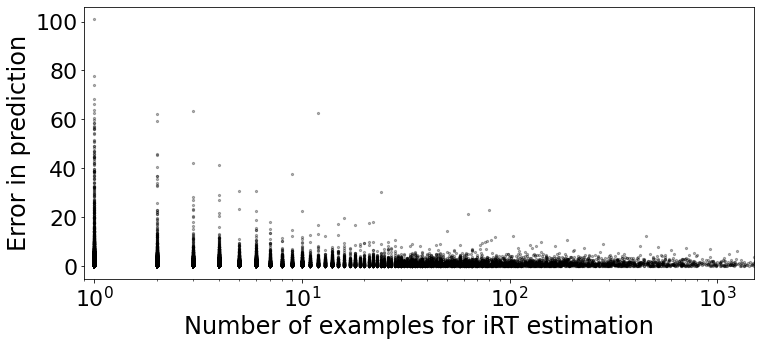

In [ ]:
corr_by_count(scaler.scale_*valid_y + scaler.mean_, 
              scaler.scale_*pred_valid_y + scaler.mean_,
              valid.hits.values)

Interestingly, I think better than any other plot that this shows exactly the benefit that we are getting with increased PSMs in the database. The predictive error is directly related to the number of examples for estimating the database iRT, which is a great result.

### Finalizing Model

In [ ]:
model = get_best_model(wd + "trained_models/update_20210902/retention_time/phospho_single_layer_gru/2fc8d3d6-2f2f-4284-bfec-48a6cd5d2110/")

**Plain Model:**

In [ ]:
config = model.to_json()
with open(wd + "trained_models/update_20210902/export/phospho_rt_gru_512.config.json", "w") as dest:
    dest.write(config)

model.save_weights(wd + "trained_models/update_20210902/export/phospho_rt_gru_512.weights.h5", 
                   save_format="h5")

**Phosphopedia Model:**

In [ ]:
model.layers[-1].set_weights(
    [model.layers[-1].get_weights()[0] * scaler.scale_,
     model.layers[-1].get_weights()[1] * scaler.scale_ + scaler.mean_]
)

config = model.to_json()
with open(wd + "trained_models/update_20210902/export/human_phosphopedia_rt.config.json", "w") as dest:
    dest.write(config)

model.save_weights(wd + "trained_models/update_20210902/export/human_phosphopedia_rt.weights.h5", 
                   save_format="h5")